In [1]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
from myImports import *
%matplotlib inline

In [2]:
cacatoes_dir_path = "/homedata/fiolleau/RCE/CACATOES/"

In [3]:
#Open CACATOES data, 
ds = xr.open_dataset(cacatoes_dir_path+"cacatoes_rcemip_SAM_RCE_large300_2D.nc")
ds["time"] = (ds["time"]/8.64e13).astype(int)
ds = ds.isel(time=slice(None, -1)) ## Last day empty imo 
ds

<xarray.Dataset>
Dimensions:                       (Y: 4, X: 62, time: 25, CondPrecip: 17,
                                   MCS: 150)
Coordinates:
  * time                          (time) int64 0 1 2 3 4 5 ... 19 20 21 22 23 24
  * CondPrecip                    (CondPrecip) int16 0 1 2 3 4 ... 25 30 35 40
Dimensions without coordinates: Y, X, MCS
Data variables: (12/41)
    Ygrid                         (Y) float32 ...
    Xgrid                         (X) float32 ...
    DAILYmcs_Pop                  (time, Y, X) float32 ...
    DAILY_OLR                     (time, Y, X) float32 ...
    DAILY_precip                  (time, Y, X) float32 ...
    DAILY_conditionalprecip       (time, CondPrecip, Y, X) float32 ...
    ...                            ...
    INT_gridtimeOccupation_start  (time, MCS, Y, X) float64 ...
    INT_gridtimeOccupation_end    (time, MCS, Y, X) float64 ...
    INT_surfFraction_235K         (time, MCS, Y, X) float32 ...
    INT_surfFraction_220K         (time, MCS, Y, X) float32 ...
    INT_surfFraction_210K         (time, MCS, Y, X) float32 ...
    INT_surfFraction_200K         (time, MCS, Y, X) float32 ...

In [5]:
## Data exploration 
#MCS_Pop = ds["DAILYmcs_Pop"].values ## Distinc count on the labels ; Pop = Nbr of MCS
MCS_label=ds["QCmcs_label"].values ## label to make the join with on tracking file
#MCS_flag= ds["QCmcs_label"].values ## deprecated, identical to MCS_label
#MCS_init = ds["INIT_time"].values ## weird, one fist day the max is over 24, but the max still thend to increase of 40 per day 
#MCS_surfmax_235K = ds["INT_surfmaxkm2_235K"] ## weird, when selecting a day and a MCS, data is spread all over X Y. So X and Y don't represent the location of the MCS ? 
                                             ## + values seem to be overall decreasing as if the MCS were ordered
MCS_surface = ds["INT_surfMCS"].values

MCS_label[0, 0, 0, 15:17] ## same MCS over two grid points # array([22404., 22404.])
MCS_surface[0, 0, 0, 15:17]


array([801., 765.], dtype=float32)

In [6]:
surfMCS = ds["INT_surfMCS"].values
surfGrid = ds["QCcacatoes_SurfGridPoint"].values

In [7]:
## Data processing 
from myFuncs import Ponderate_MCS_by_surface

MCS_Speed = Ponderate_MCS_by_surface(ds["INT_vavg"].values, surfMCS, surfGrid, weight = False, rel_weight = False, ExtensiveVariable=False) #INT_vavg
MCS_QuantityMovement = Ponderate_MCS_by_surface(ds["INT_vavg"].values, surfMCS, surfGrid, weight = True, rel_weight = False, ExtensiveVariable=True) #INT_vavg
MCS_KineticEnergy = Ponderate_MCS_by_surface(np.multiply(ds["INT_vavg"].values, ds["INT_vavg"].values), surfMCS, surfGrid, weight = True, rel_weight = False, ExtensiveVariable=True) #INT_vavg
MCS_Duration = Ponderate_MCS_by_surface(ds["INT_duration"].values, surfMCS, surfGrid, weight = False, rel_weight = False, ExtensiveVariable=False) #INT_duration
MCS_Distance = Ponderate_MCS_by_surface(ds["INT_distance"].values, surfMCS, surfGrid, weight = False, rel_weight = False, ExtensiveVariable=False) #INT_distance
MCS_Radiation = Ponderate_MCS_by_surface(ds["INT_OLRmin"].values, surfMCS, surfGrid, weight = False, rel_weight = False, ExtensiveVariable=False) #INT_OLRmin
MCS_CumSurface = Ponderate_MCS_by_surface(ds["INT_Scum"].values, surfMCS, surfGrid, weight = False, rel_weight = False, ExtensiveVariable=True) #INT_Scum
MCS_Surface = Ponderate_MCS_by_surface(ds["INT_surfMCS"].values, surfMCS, surfGrid, weight = False, rel_weight = False, ExtensiveVariable=True) #INT_surfMCS


/home/mcarenso/code/stage-2023-multiscale-extremes/scripts/src/myFuncs.py:83: RuntimeWarning: Mean of empty slice
  rel_MCS_data_mean_nan = np.nanmean(np.where(data==0, np.nan, data), axis=1) ## average with nan mean, after replacing 0 values by nan.


In [8]:
ref = "DAILY_precip"
ref_dist_IL = cs.Distribution(name = ref, bintype = "invlogQ", nd =4, fill_last_decade=False)
ref_dist_IL.computeDistribution(sample = ds[ref][:].values,vmin = 0)
ref_dist_IL.storeSamplePoints(sample = ds[ref][:].values, verbose= True)


Finding bin locations...
bin #: 0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..



/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [9]:
#Pop
cond_dist_Pop = cs.ConditionalDistribution(name="DAILYmcs_Pop on "+ref, is3D=False, on=ref_dist_IL)
cond_dist_Pop.computeConditionalMeanAndVariance(sample=ds["DAILYmcs_Pop"][:].values,verbose=False) #Pop
#OLR
cond_dist_OLR = cs.ConditionalDistribution(name="DAILY_OLR on "+ref, is3D=False, on=ref_dist_IL)
cond_dist_OLR.computeConditionalMeanAndVariance(sample=ds["DAILY_OLR"][:].values,verbose=False) # OLR

In [10]:
#Speed
cond_dist_Speed = cs.ConditionalDistribution(name="MCS_Speed "+ref, is3D=False, on=ref_dist_IL)
cond_dist_Speed.computeConditionalMeanAndVariance(sample=MCS_Speed,verbose=False)
#QuantityMovement
cond_dist_QuantityMovement = cs.ConditionalDistribution(name="MCS_QuantityMovement "+ref, is3D=False, on=ref_dist_IL)
cond_dist_QuantityMovement.computeConditionalMeanAndVariance(sample=MCS_QuantityMovement,verbose=False)
#KineticEnergy
cond_dist_KineticEnergy = cs.ConditionalDistribution(name="MCS_KineticEnergy "+ref, is3D=False, on=ref_dist_IL)
cond_dist_KineticEnergy.computeConditionalMeanAndVariance(sample=MCS_KineticEnergy,verbose=False)
#Duration
cond_dist_Duration = cs.ConditionalDistribution(name="MCS_Duration "+ref, is3D=False, on=ref_dist_IL)
cond_dist_Duration.computeConditionalMeanAndVariance(sample=MCS_Duration,verbose=False)
#Distance
cond_dist_Distance = cs.ConditionalDistribution(name="MCS_Distance "+ref, is3D=False, on=ref_dist_IL)
cond_dist_Distance.computeConditionalMeanAndVariance(sample=MCS_Distance,verbose=False)
#Radiation
cond_dist_Radiation = cs.ConditionalDistribution(name="MCS_Radiation "+ref, is3D=False, on=ref_dist_IL)
cond_dist_Radiation.computeConditionalMeanAndVariance(sample=MCS_Radiation,verbose=False)
#CumSurface
cond_dist_CumSurface = cs.ConditionalDistribution(name="MCS_CumSurface "+ref, is3D=False, on=ref_dist_IL)
cond_dist_CumSurface.computeConditionalMeanAndVariance(sample=MCS_CumSurface,verbose=False)
#Speed
cond_dist_Surface = cs.ConditionalDistribution(name="MCS_Surface "+ref, is3D=False, on=ref_dist_IL)
cond_dist_Surface.computeConditionalMeanAndVariance(sample=MCS_Surface,verbose=False)


In [11]:
cond_dists = [cond_dist_Pop, cond_dist_OLR, cond_dist_Speed, cond_dist_QuantityMovement, cond_dist_KineticEnergy, cond_dist_Duration, 
              cond_dist_Distance, cond_dist_Radiation, cond_dist_CumSurface, cond_dist_Surface]
names = ["Pop", "OLR", "Speed", "QuantityMovement", "KineticEnergy", "Duration", "Distance", "Radiation", "CumSurface", "Surface"]

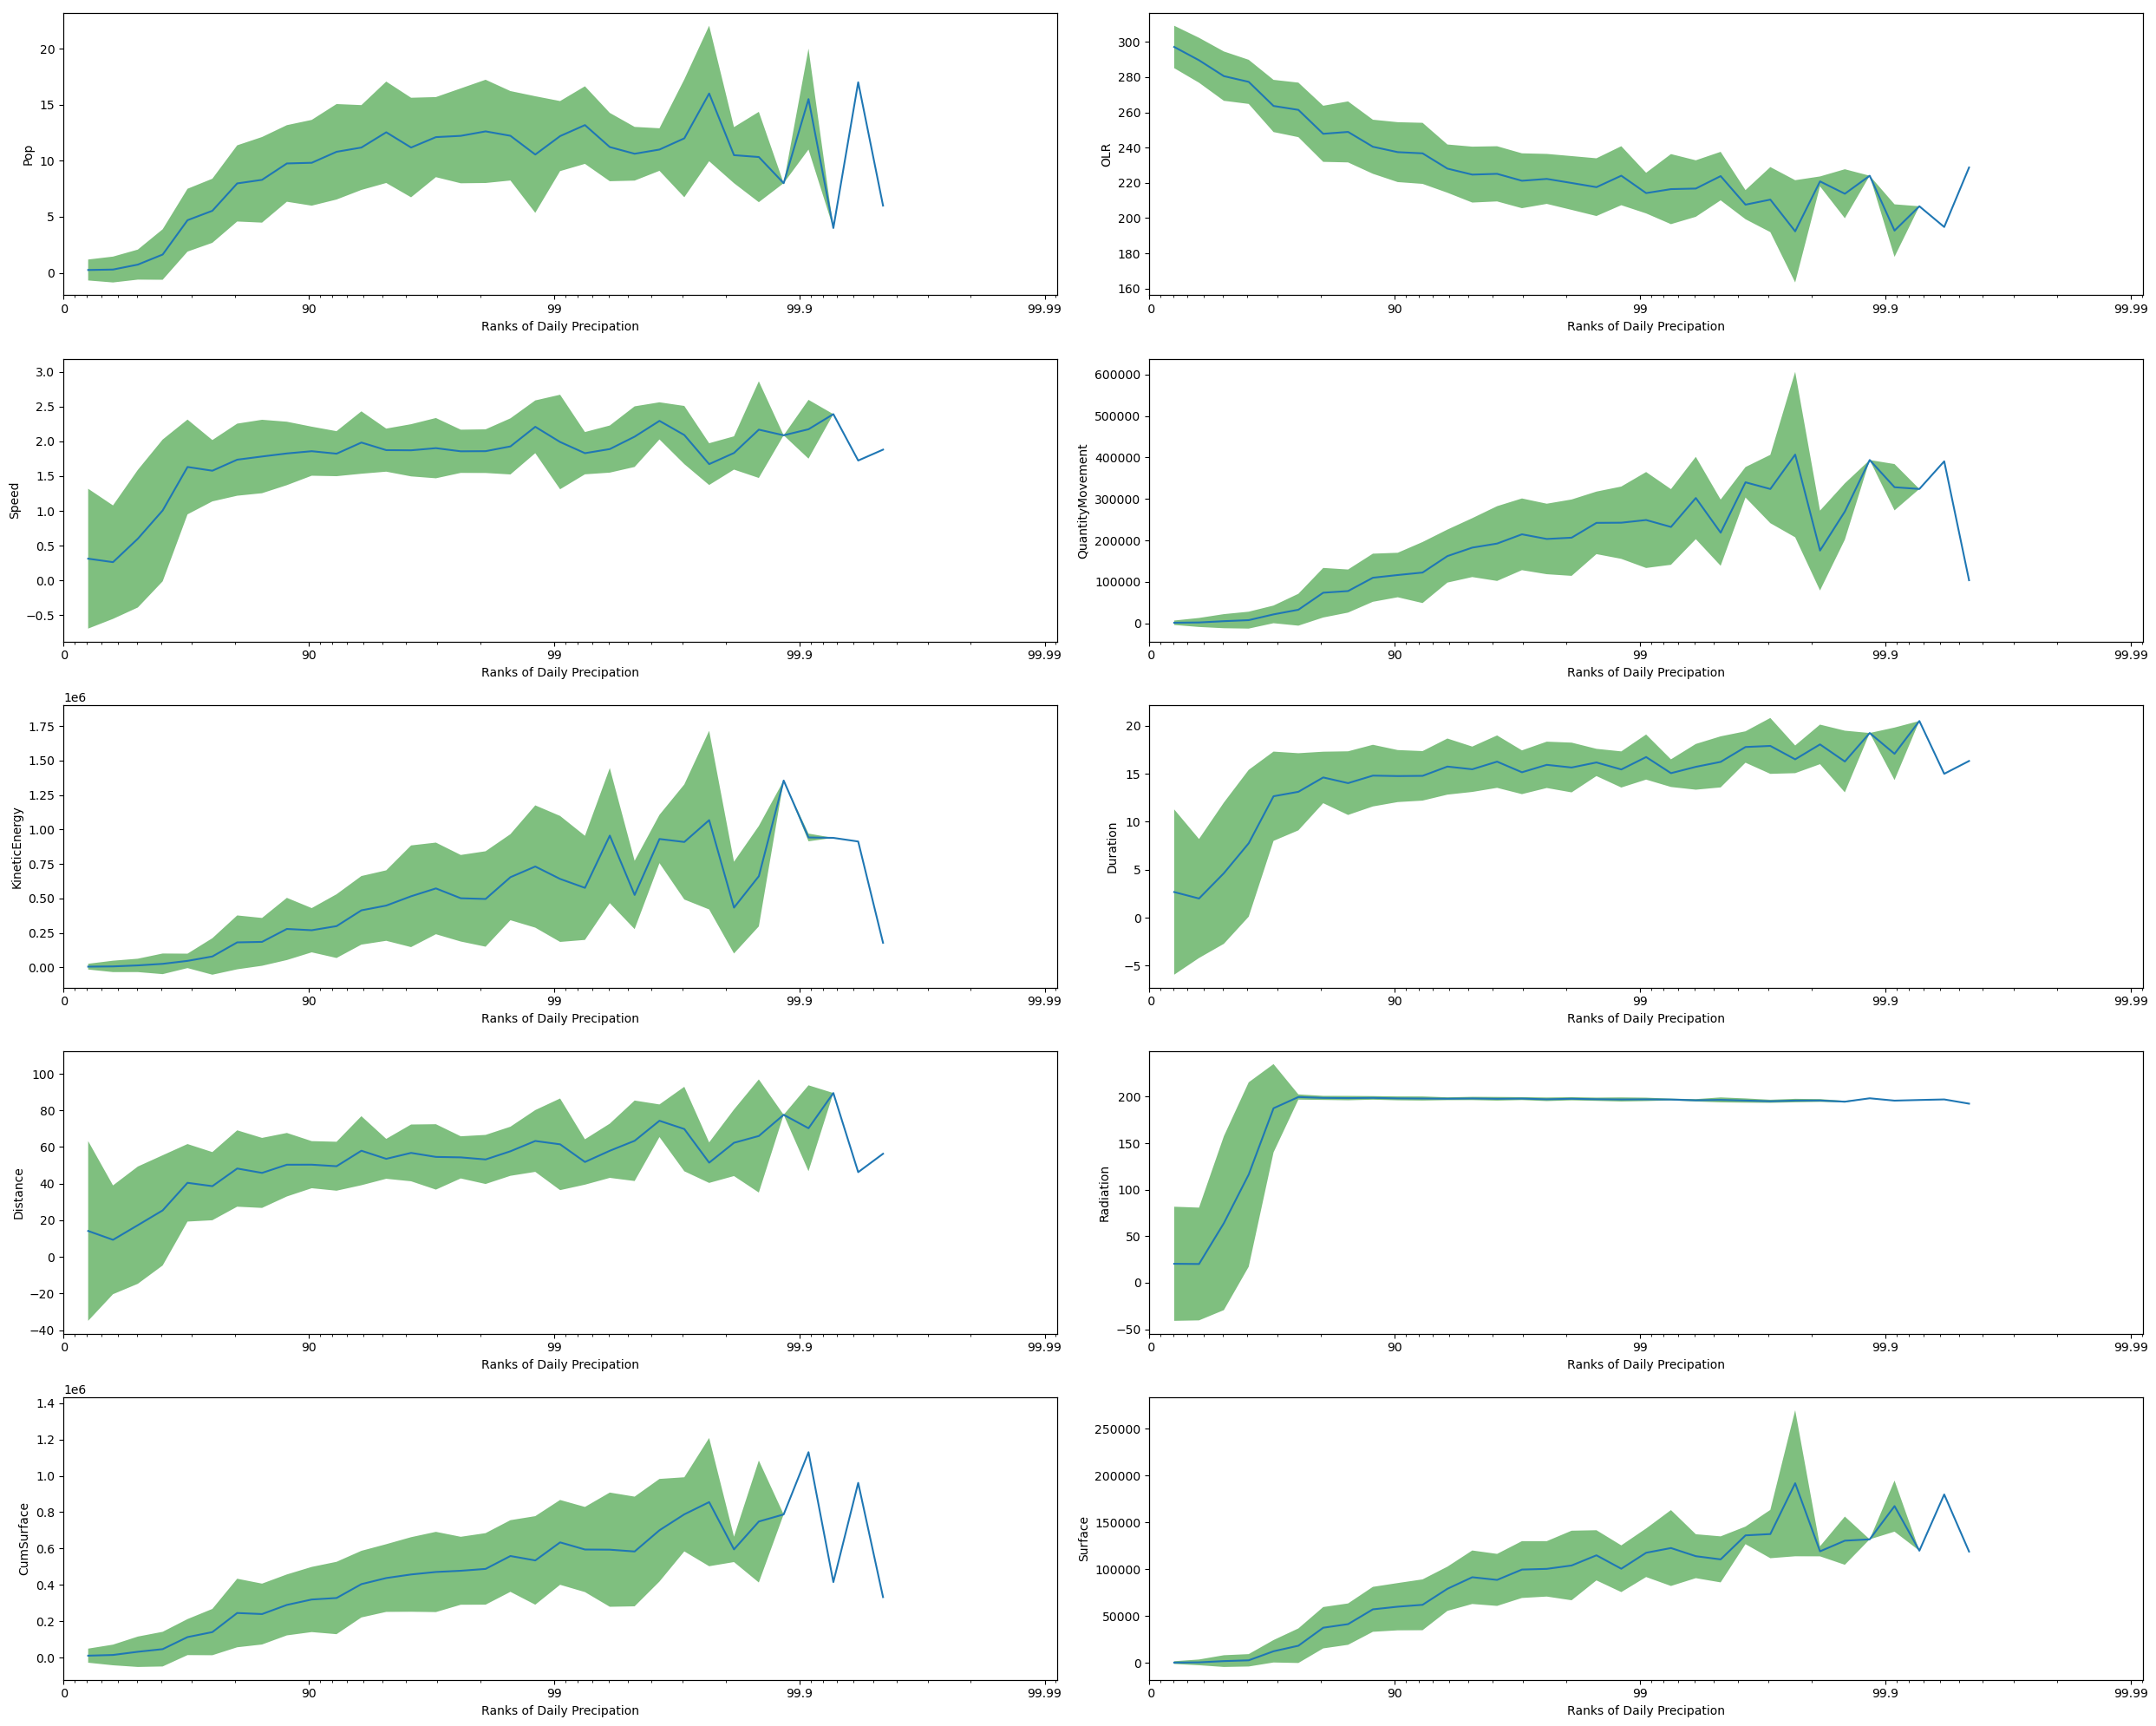

In [14]:
fig,axs = plt.subplots(nrows = 5, ncols=2, figsize = (25,20))
# plot mean
for cd, n, ax in zip(cond_dists, names, axs.flatten()):
    x = cd.on.ranks
    ax_show = ax.twiny()
    setXaxisIL(ax, x) ## TODO : try with setframeIL ? 
    #showData(ax_show, cd.on.ranks, cd.cond_mean)
    #ax_show.plot(cd.on.ranks,cd.cond_mean,'k')
    
    # plot 1-sigma standard error
    mean = cd.cond_mean
    std = np.sqrt(cd.cond_var)
    fillBetweenShowData(ax_show, x, mean, std, facecolor='g', alpha=0.5, interpolate=True)
    # #showData(ax_show, x, y1, color = 'r', alpha = 0.5)
    # #showData(ax_show, x, y2, color = 'r', alpha = 0.5)
    ax.set_xlabel("Ranks of Daily Precipation")
    ax.set_ylabel(n)
plt.tight_layout()
plt.show()